In [1]:
#要降版本, 不然程式會有問題
%tensorflow_version 1.x
import tensorflow as tf

tf.__version__

# Install the latest Tensorflow version.
!pip install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip install tensorflow-hub
# Install imageio for creating animations.  
!pip install imageio

TensorFlow 1.x selected.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.15.2 which is incompatible.


In [2]:
#@title Imports and function definitions

import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time
from IPython import display
from skimage import transform

# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512


# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)


# Given a set of images, show an animation.
def animate(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  with open('./animation.gif','rb') as f:
      display.display(display.Image(data=f.read(), height=300))


# Simple way to display an image.
def display_image(image):
  plt.figure()
  plt.axis("off")
  plt.imshow(image)


# Display multiple images in the same figure.
def display_images(images, captions=None):
  num_horizontally = 5
  f, axes = plt.subplots(
      len(images) // num_horizontally, num_horizontally, figsize=(20, 20))
  for i in range(len(images)):
    axes[i // num_horizontally, i % num_horizontally].axis("off")
    if captions is not None:
      axes[i // num_horizontally, i % num_horizontally].text(0, -3, captions[i])
    axes[i // num_horizontally, i % num_horizontally].imshow(images[i])
  f.tight_layout()

tf.logging.set_verbosity(tf.logging.ERROR)

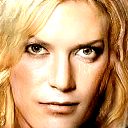

In [3]:
def interpolate_between_vectors():
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")

    # Change the seed to get different random vectors.
    v1 = tf.random_normal([latent_dim], seed=3)
    v2 = tf.random_normal([latent_dim], seed=1)
    
    # Creates a tensor with 50 steps of interpolation between v1 and v2.
    vectors = interpolate_hypersphere(v1, v2, 25)

    # Uses module to generate images from the latent space.
    interpolated_images = module(vectors)

    with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      interpolated_images_out = session.run(interpolated_images)

    animate(interpolated_images_out)

interpolate_between_vectors()

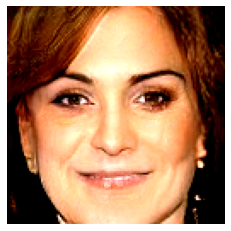

In [4]:
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }

def get_module_space_image():
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")
    vector = tf.random_normal([1, latent_dim], seed=4)
    images = module(vector)

    with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      image_out = session.run(images)[0]
  return image_out

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[uploaded.keys()[0]])
  return transform.resize(image, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()
display_image(target_image)

0.688769
5.607328
5.049135
2.725675
0.73154974
1.4969605
0.82845354
1.147059
1.4738402
0.78106093
0.8780064
1.2609408
0.8296215
0.5127669
0.7657167
0.28119412
1.0127039
1.3107775
0.957603
0.17578664
0.38918257
0.22698265
0.20097658
0.37962362
0.1464316
0.8295889
0.9538052
0.50049645
0.64079463
0.9423418
0.6885255
0.25500512
0.40413067
0.17227611
0.18611047
0.35647076
0.16538653
0.6988709
0.7978394
0.37108275


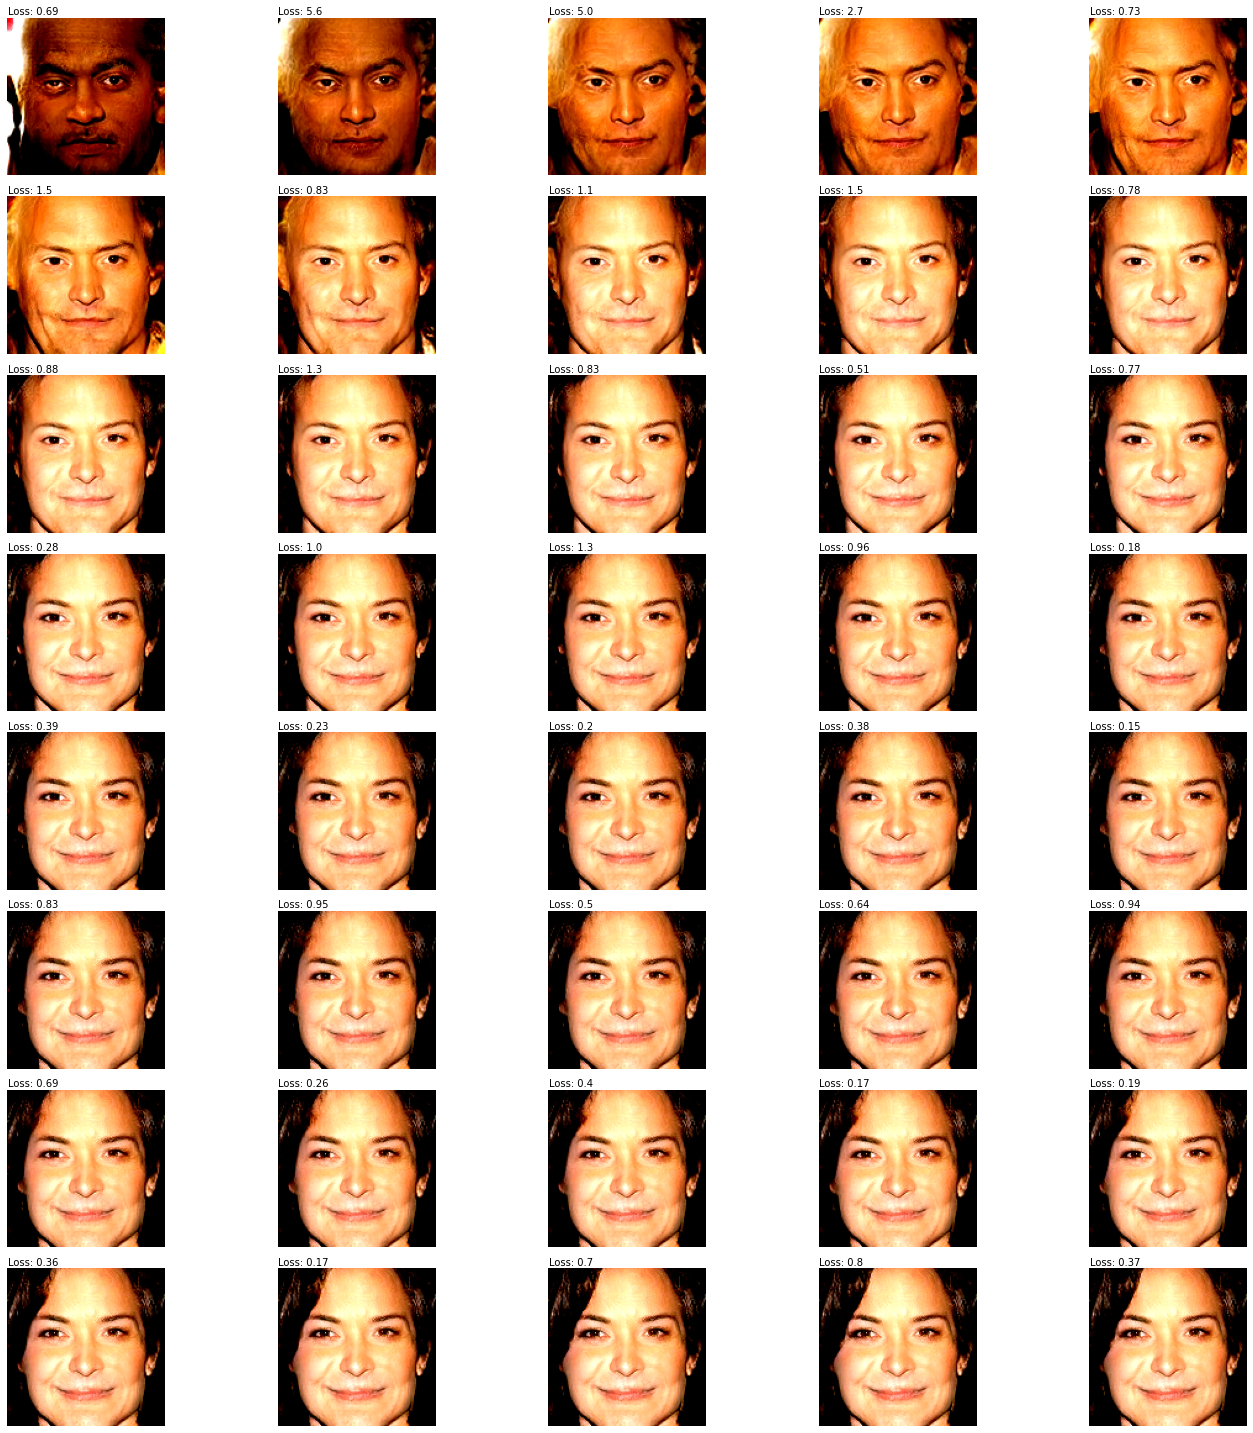

In [5]:
def find_closest_latent_vector(num_optimization_steps):
  images = []
  losses = []
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")

    initial_vector = tf.random_normal([1, latent_dim], seed=5)

    vector = tf.get_variable("vector", initializer=initial_vector)
    image = module(vector)

    target_image_difference = tf.reduce_sum(
        tf.losses.absolute_difference(image[0], target_image[:,:,:3]))

    # The latent vectors were sampled from a normal distribution. We can get
    # more realistic images if we regularize the length of the latent vector to 
    # the average length of vector from this distribution.
    regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))
    
    loss = target_image_difference + regularizer
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.3)
    train = optimizer.minimize(loss)

    with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      for _ in range(num_optimization_steps):
        _, loss_out, im_out = session.run([train, loss, image])
        images.append(im_out[0])
        losses.append(loss_out)
        print(loss_out)
    return images, losses


result = find_closest_latent_vector(num_optimization_steps=40)

captions = [ f'Loss: {l:.2}' for l in result[1]]
display_images(result[0], captions)